In [1]:
from fastai.text import *

In [84]:
bs = 8
path = 'data/Amazon_zip'

In [39]:
# Random seed
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [85]:
data_lm = load_data(path, 'Amazon_lm.pkl', bs=bs)

In [93]:
#data_clas = load_data(path, 'AZ_data_clas.pkl')
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder()
             #label them all with their folders
             .databunch(bs=bs, num_workers=0))

In [104]:
x,y = data_clas.one_batch()
x.shape,y.shape

(torch.Size([8, 926]), torch.Size([8]))

In [105]:
nv = len(data_lm.vocab.itos); nv

28376

In [106]:
nh=64

In [107]:
def loss4(input,target): return F.cross_entropy(input, target[:,-1])
def acc4 (input,target): return accuracy(input, target[:,-1])

In [111]:
x[:,0]

tensor([2, 1, 1, 1, 1, 1, 1, 1])

In [102]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh, bias = True)     # brown arrow
        self.h_o = nn.Linear(nh,nv, bias = True)     # blue arrow
        #self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

In [115]:
learn = Learner(data_clas, Model0(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [116]:
random_seed(42, True)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


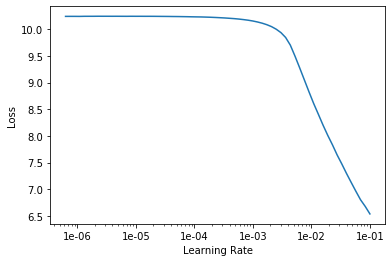

In [49]:
learn.recorder.plot()

In [51]:
random_seed(42, True)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,9.264159,6.449415,0.500000,00:02
1,4.636208,0.821684,0.500000,00:02
2,2.797581,0.719461,0.506250,00:02
3,1.926970,0.688337,0.540625,00:02
4,1.446981,0.689551,0.546875,00:02
5,1.156872,0.715222,0.553125,00:02
6,0.955474,0.730371,0.571875,00:02
7,0.810085,0.761374,0.562500,00:02
8,0.699883,0.792561,0.515625,00:02
9,0.619736,0.785503,0.556250,00:02


In [56]:
learn.predict('terrible')

(Category genuine,
 tensor(1),
 tensor([4.8796e-04, 1.2139e-03, 4.4178e-05,  ..., 3.6230e-05, 5.1630e-05,
         3.2708e-05]))

In [117]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.460823,1.069093,0.500000,00:15
1,0.829398,0.724629,0.537500,00:15
2,0.730997,0.702618,0.500000,00:15
3,0.677086,0.797885,0.534375,00:15
4,0.574198,0.828662,0.550000,00:15
5,0.463816,0.891396,0.540625,00:15
6,0.376739,1.015360,0.543750,00:15
7,0.300631,1.143209,0.528125,00:15
8,0.179570,1.547185,0.537500,00:15
9,0.130676,1.593589,0.543750,00:15


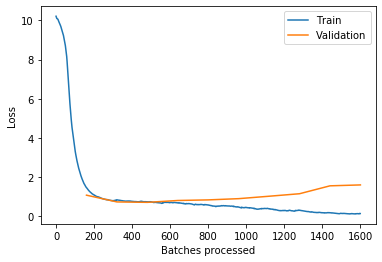

In [118]:
learn.recorder.plot_losses()

In [ ]:
#fin